# Embedding and Bias Analysis - a linear algebra approach

related to https://stdm.github.io/downloads/papers/ANNPR_2020.pdf


### Projection 

The centers of the 4 racial clusters span a (4-1)d=3d subspace of the embedding space. This 3d space is visualized below (section 1). Remarks:
- This simple construction yields nice clusters
- The structure of the clusters can be easily explored as it is in 3d
- By construction, it is a proper subspace of a the embedding vector space. 
- Therefore, the empedding space is partitioned in a 3d "racial" space and a (n-3)d "racially blinded" space (see PCA in section 5)
- Also, each substance has a well defined variance and contributes accordingly to the total variance (see section 2). There variance of the race contributes 7-15% to the total variance depending on the model.

### Clustering scores

Section 3 gives the clustering scores. They indicate marginal clustering for the full embedding space, decent clustering for the 3d subspace and no clustering for the remaining subspace. As a consequence, the clustering scores reflect clustering in 3 dimensions and are not a measure for the whole embedding space. Since face recognition includes the whole embedding space, clustering scores cannot expected to be representative (as the paper shows...).

The distance analysis in section 4 shows that "nearest neighebor distances between clusters < pairwise distances within a single cluster". This reflects the fact, that the clustering is marginal in the total embedding space.


### What can we do then about the bias?

Still, wie have the problem, that the recognition rate depend on race. I assume the main reason is that discriminating face characteristics within a given race were not equally well trained for different races. Or simpler: The training set for Caucasians was much bigger. The algorithm is better trained to dicriminate face characteristics of Caucasians. 

So, how to proceed?
- Difference in recognition rate should be measured directly with personal labels. Done in https://arxiv.org/abs/2009.07838. Idea from this paper: Include false positive rate
- Looking where false positive/negative are located in the 3d race space may give a hint where to do further training 


### Further ideas

- This projection approach opens a new route to shed light into the embedding space. The different dimensions become meaning. The contribution of different face characteristics to the embedding space can be quantified.
- Explore the face recognition rate of the "racially blinded" subspace.
- ...


### Literatur, Links
- https://towardsdatascience.com/introduction-to-best-parallel-plot-python-library-hiplot-8387f5786d97
- https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/



### Import and Helpers

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import hiplot as hip
from sklearn.decomposition import PCA
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import NearestNeighbors
from scipy.linalg import orth
from scipy.spatial.distance import cosine
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

mystore = r'C:\Daten\_tmp\FRdata.h5'

In [131]:
class H5Reader:
    pattern = r'C:\Daten\FaceRecognitionBias\senet50\embeddings\{net}_pytorch_{race}_normed_BGR.h5'
    race_list = ['Caucasian','Indian','Asian','African']
    net_list = ['senet50_128','senet50_256','senet50_ft']
    
    
    def __init__(self, net):
        self.net = net
        
    @classmethod
    def net(cls, ind):
        return cls.net_list[ind]
        
    @classmethod
    def race(cls, ind):
        if type(ind) == str:
            return list(filter(lambda s: s.lower().startswith(ind.lower()),cls.race_list))[0]
        else:
            return cls.race_list[ind]
        
    def path(self, race):
        race = list(filter(lambda s: s.lower().startswith(race.lower()),self.race_list))[0]
        return self.pattern.format(net = self.net, race = race)
        
    def read(self, race_prefix, race_index = False, key = '/embeddings'):
        race = self.race(race_prefix)
        path = self.pattern.format(net = self.net, race = race)
        df = pd.read_hdf(path, key)
        if race_index:
            df['race_index'] = self.race_list.index(race)
        return df
    
    def read_all(self, N=None, select = 'head', key = '/embeddings'):
        out = []
        for race in self.race_list:
            df = self.read(race, race_index=True, key = key)
            if N is None:
                out.append(df)
            elif select == 'head':
                out.append(df.head(N))
            else:
                out.append(df.tail(N))    
                
        return pd.concat(out,0).set_index('race_index').reset_index()
    
    def read_pair_labels(self, N=None, select = 'head'):
        df = self.read_all(key='/images',N=N, select=select)
        return (df['class'] + '_' + df.img.apply(lambda s: s[:-4].split('.')[1])).values
        
                
    def keys(self, race_prefix):    
        race = self.race(race_prefix)
        path = self.pattern.format(net = self.net, race = race)
        with pd.HDFStore(path) as hdf:
            out = hdf.keys()
        return out
    
    @staticmethod
    def df2data(df):
        return df.filter(regex='\d').values, df.filter(regex='\D').values.flatten()
    
    @staticmethod
    def replacedata(df,X):
        return pd.concat([df.filter(regex='\D'), pd.DataFrame(X)],1)
    
    
r128 = H5Reader('senet50_128')
r128.read_pair_labels()

array(['Caucasian_0cl29w_0001', 'Caucasian_0cl29w_0003',
       'Caucasian_0cl29w_0002', ..., 'African_05c1c5_0003',
       'African_05c1c5_0002', 'African_05c1c5_0001'], dtype=object)

In [222]:
# a class to project on subspaces
class ClusterCenterProjection:
    
    def fit(self,X, labels):
        centers = np.array([np.mean(X[labels==label,:],0) for label in np.unique(labels)])
        vectors = centers[1:,:] - centers[:1,:]
        self._basis = (vectors[0,:]/np.linalg.norm(vectors[0,:])).reshape([1,-1])
        # gram schmidt orthogonalization
        for iv in range(1,vectors.shape[0]):
            new_basis_vector = self.blind(vectors[iv,:])
            new_basis_vector = (new_basis_vector / np.linalg.norm(new_basis_vector)).reshape([1,-1])
            self._basis = np.concatenate([self._basis, new_basis_vector])
              

    def fit2(self,X, labels):
        centers = np.array([np.mean(X[labels==label,:],0) for label in np.unique(labels)])
        self._basis = orth((centers[1:,:] - centers[:1,:]).T).T
        
    def project(self,X, keepdims = False):
        out = np.dot(X,self._basis.T)
        if keepdims:
            out = np.dot(out, self._basis)
        return out
    
    def blind(self, X):
        return X - self.project(X,keepdims=True)
        
ccp = ClusterCenterProjection()
df = H5Reader('senet50_128').read_all()
X,y = H5Reader.df2data(df)
ccp.fit(X,y)
df = H5Reader.replacedata(df,ccp.blind(X))

### Class for face recognition distances between defined  (RFW) pairs 

- you need the labels m.0bmgl10_0001 -> The devine the images uniquely
- the metric works in the space of pairs: pair_dist = fun(pair, embeddings+label). pair_label = fun(pair_distance)
- The threshold in the paper is on cosine distances  (but could be euclidean as well)
- Note: Some people Ids (example '01pw5d') occur in several races (african & indian for the example). However, pairs are defined strictly within race. Therefore I don't know whether these are the same person... 


https://openaccess.thecvf.com/content_ICCV_2019/papers/Wang_Racial_Faces_in_the_Wild_Reducing_Racial_Bias_by_Information_ICCV_2019_paper.pdf

In [214]:
class RFWDistances:
    pattern = r'C:\Daten\FaceRecognitionBias\RFW\{race}\{race}_pairs.txt'
    race_list = ['Caucasian','Indian','Asian','African']
    
    @staticmethod
    def _label1(s):
        s = s.split('\t')
        return s[0].split('.')[1] + '_' + s[1].zfill(4)

    @staticmethod
    def _label2(s):
        s = s.split('\t')
        if len(s) == 3:
            return s[0].split('.')[1] + '_' + s[2].zfill(4)
        else:
            return s[2].split('.')[1] + '_' + s[3].zfill(4)
        
    @staticmethod
    def _issame(s):
        return np.int8(len(s.split('\t'))==3)
        
    def __init__(self):
        df = [pd.read_csv(self.pattern.format(race=race),header=None).assign(race=race) for race in self.race_list]
        df = pd.concat(df,0).reset_index(drop=True)
        df['label1'] = df.race + '_' + df[0].apply(self._label1)
        df['label2'] = df.race + '_' + df[0].apply(self._label2)
        df['issame'] = df[0].apply(self._issame)
        self._df = df.drop(columns=[0])

    def get_distance_df(self, embeddings, labels):
        edf = pd.DataFrame(embeddings)
        edf.index = labels

        df = self._df.copy()
        X1 = edf.reindex(df.label1).values
        X2 = edf.reindex(df.label2).values
        df['cos'] = np.array([cosine(X1[ii], X2[ii]) for ii in range(X1.shape[0])])
        df['eucl'] = np.linalg.norm(X1-X2,axis=1)
        return df
    
r128 = H5Reader('senet50_128')
labels = r128.read_pair_labels()
embeddings = r128.read_all().filter(regex=r'\d')

frm = RFWDistances()
df = frm.get_distance_df(embeddings,labels).dropna()
df.head()

,race,label1,label2,issame,cos,eucl
0,Caucasian,Caucasian_027n6t8_0003,Caucasian_027n6t8_0002,1,0.397336,0.891444
1,Caucasian,Caucasian_016lb3_0004,Caucasian_016lb3_0002,1,0.355929,0.843717
2,Caucasian,Caucasian_02_4qt_0003,Caucasian_02_4qt_0002,1,0.330190,0.812638
3,Caucasian,Caucasian_09g8fj_0003,Caucasian_09g8fj_0001,1,0.294455,0.767405
4,Caucasian,Caucasian_01q3xr_0001,Caucasian_01q3xr_0003,1,0.280291,0.748720


# 1. Subspace projection (3D) 

In a first step I project the empeddings into a 3D-space spannend by the centers (averages) of the clusters. As a result I get beautifully structured clusters.

### senet50_128

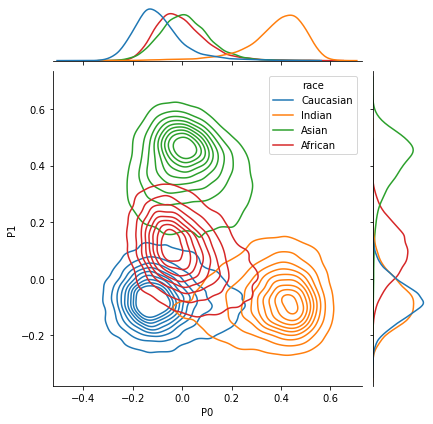

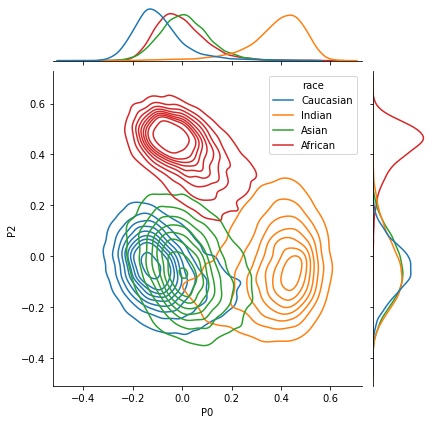

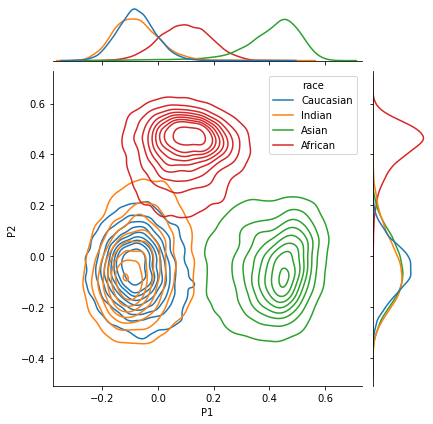

In [7]:
rd = H5Reader('senet50_128')
df = rd.read_all(9500)
ccp = ClusterCenterProjection()
X, labels = H5Reader.df2data(df)
ccp.fit(X,labels)
P3d_df = H5Reader.replacedata(df,ccp.project(X)).rename(columns={0:'P0',1:'P1',2:'P2'})
P3d_df['race'] = P3d_df.race_index.apply(H5Reader.race)

sns.jointplot(x='P0', y='P1',hue='race',data=P3d_df,kind="kde")
plt.show()
sns.jointplot(x='P0', y='P2',hue='race',data=P3d_df,kind="kde")
plt.show()
sns.jointplot(x='P1', y='P2',hue='race',data=P3d_df,kind="kde")
plt.show()

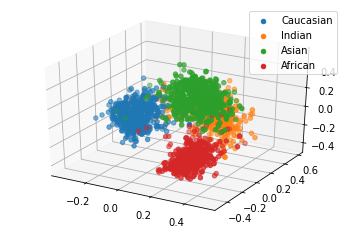

In [5]:
# %matplotlib notebook
N = 500
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for ir in P3d_df.race_index.unique():
    sel = P3d_df.race_index == ir
    ax.scatter(P3d_df[sel]['P0'][:N], P3d_df[sel]['P1'][:N], P3d_df[sel]['P2'][:N],label=H5Reader.race(ir))
ax.legend()

### senet50_256

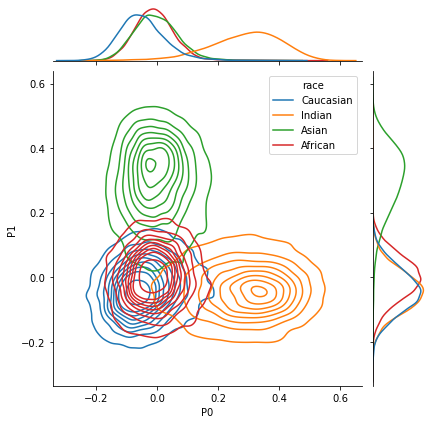

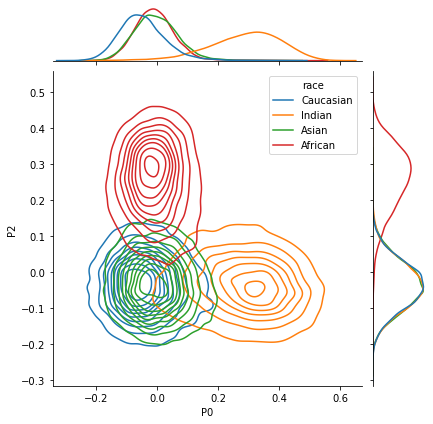

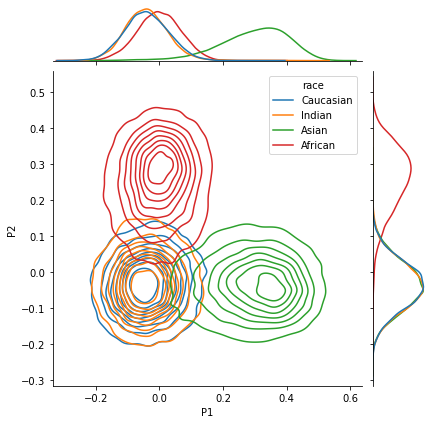

In [8]:
rd = H5Reader('senet50_256')
df = rd.read_all(9500)
ccp = ClusterCenterProjection()
X, labels = H5Reader.df2data(df)
ccp.fit(X,labels)
P3d_df = H5Reader.replacedata(df,ccp.project(X)).rename(columns={0:'P0',1:'P1',2:'P2'})
P3d_df['race'] = P3d_df.race_index.apply(H5Reader.race)

sns.jointplot(x='P0', y='P1',hue='race',data=P3d_df,kind="kde")
plt.show()
sns.jointplot(x='P0', y='P2',hue='race',data=P3d_df,kind="kde")
plt.show()
sns.jointplot(x='P1', y='P2',hue='race',data=P3d_df,kind="kde")
plt.show()

### senet50_ft

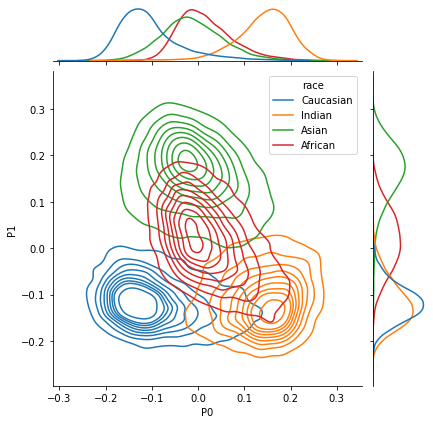

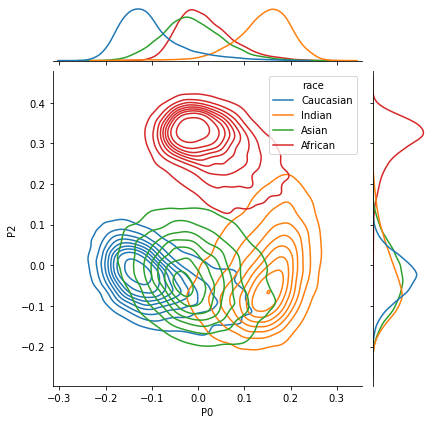

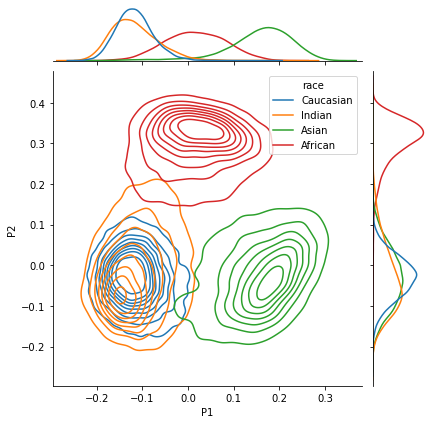

In [9]:
rd = H5Reader('senet50_ft')
df = rd.read_all(9500)
ccp = ClusterCenterProjection()
X, labels = H5Reader.df2data(df)
ccp.fit(X,labels)
P3d_df = H5Reader.replacedata(df,ccp.project(X)).rename(columns={0:'P0',1:'P1',2:'P2'})
P3d_df['race'] = P3d_df.race_index.apply(H5Reader.race)

sns.jointplot(x='P0', y='P1',hue='race',data=P3d_df,kind="kde")
plt.show()
sns.jointplot(x='P0', y='P2',hue='race',data=P3d_df,kind="kde")
plt.show()
sns.jointplot(x='P1', y='P2',hue='race',data=P3d_df,kind="kde")
plt.show()

# 2. Variance

In [22]:
vardf = []
ccp = ClusterCenterProjection()
for net in H5Reader.net_list:
    df = H5Reader(net).read_all()
    df['race'] = df.race_index.apply(H5Reader.race)
    df.drop(columns=['race_index'],inplace = True)
    X, labels = H5Reader.df2data(df)
    ccp.fit(X,labels)
    for ix,X2 in enumerate([X, ccp.project(X), ccp.blind(X)]):
        newdf = H5Reader.replacedata(df,X2).groupby('race').var().T.sum()
        newdf = pd.DataFrame(newdf,columns=['variance'])
        newdf.loc['Total',['variance']] = np.sum(np.var(X2,0))
        newdf['Net'] = net
        newdf['Type'] = {0:'full',1:'3d',2:'blinded'}[ix]
        vardf.append(newdf)

vardf = (pd.concat(vardf,0)
 .reset_index()
 .set_index(['race','Net','Type'])
 .unstack(['Net','Type'])
 .reindex(H5Reader.race_list + ['Total'])
)  

vardf

variance                                                      \
Net       senet50_128                     senet50_256                       
Type             full        3d   blinded        full        3d   blinded   
race                                                                        
Caucasian    0.962882  0.025255  0.937627    0.987675  0.014945  0.972730   
Indian       0.826110  0.038815  0.787294    0.906292  0.023025  0.883267   
Asian        0.814082  0.037556  0.776526    0.904100  0.021526  0.882575   
African      0.789606  0.028488  0.761118    0.927298  0.017653  0.909644   
Total        0.962477  0.146923  0.815550    0.985039  0.072817  0.912218   

                                          
Net       senet50_ft                      
Type            full        3d   blinded  
race                                      
Caucasian   0.394439  0.008927  0.385512  
Indian      0.385527  0.013788  0.371738  
Asian       0.394231  0.014903  0.379328  
African     0.328315  0.011973  0.316342  
Total       0.416367  0.053692  0.362674

### Percentage value relative to total variance

In [25]:
(100*vardf / vardf.values[4,[0,0,0,3,3,3,6,6,6]]).astype(float).round(1)

variance                                                          \
Net       senet50_128               senet50_256              senet50_ft         
Type             full    3d blinded        full   3d blinded       full    3d   
race                                                                            
Caucasian       100.0   2.6    97.4       100.3  1.5    98.8       94.7   2.1   
Indian           85.8   4.0    81.8        92.0  2.3    89.7       92.6   3.3   
Asian            84.6   3.9    80.7        91.8  2.2    89.6       94.7   3.6   
African          82.0   3.0    79.1        94.1  1.8    92.3       78.9   2.9   
Total           100.0  15.3    84.7       100.0  7.4    92.6      100.0  12.9   

                   
Net                
Type      blinded  
race               
Caucasian    92.6  
Indian       89.3  
Asian        91.1  
African      76.0  
Total        87.1

# 3. Interpretaion of the cluster scores 

I wonder what cluster with the same scores look like in 2d. Therefore i create two clusters out of uniform random point seperated by a distance of 1 (see figure). In order to get similar scores as in the paper, the clusters have to be very badly structured... [Wikipedia](https://de.wikipedia.org/wiki/Silhouettenkoeffizient) confirms this for the values of the Silhouette score: 

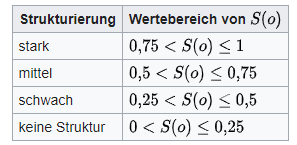

In [115]:
# functions for score calculations
def calculate_scores(X, labels):
    return {'MS': silhouette_score(X, labels),
            'CH': calinski_harabasz_score(X, labels),
            'DB': davies_bouldin_score(X, labels)}

def uniform_2d_clusters(w,N=1000):
    labels = np.int8(np.arange(2*N)/N)
    X = np.concatenate([labels.reshape([-1,1]),w*np.random.uniform(size=[2*N,1])],1)
    return X, labels

### Full empedding space

In [116]:
# reproduce scores of the paper
score_df = []
for net in H5Reader.net_list:
    df = H5Reader(net).read_all()
    X, labels = H5Reader.df2data(df)    
    out = calculate_scores(X, labels)
    score_df.append(pd.DataFrame(pd.Series(out),columns=[net]))
score_df = pd.concat(score_df,1).T
score_df

,MS,CH,DB
senet50_128,0.062520,1814.013511,3.849993
senet50_256,0.029696,772.702830,6.180902
senet50_ft,0.050755,1480.753377,4.449591


### 3d "racial" space

In [120]:
# scores of cluster projected onto 3d space (see below)
score_df = []
for net in H5Reader.net_list:
    df = H5Reader(net).read_all()
    X, labels = H5Reader.df2data(df)
    ccp = ClusterCenterProjection()
    ccp.fit(X,labels)
    out = calculate_scores(ccp.project(X,keepdims=True), labels)
    score_df.append(pd.DataFrame(pd.Series(out),columns=[net]))
score_df = pd.concat(score_df,1).T
score_df

,MS,CH,DB
senet50_128,0.532320,47401.302535,0.633584
senet50_256,0.445669,37376.483684,0.753675
senet50_ft,0.504623,44906.177659,0.696603


### "racially blinded" space

In [121]:
# scores of cluster projected onto 3d space (see below)
score_df = []
for net in H5Reader.net_list:
    df = H5Reader(net).read_all()
    X, labels = H5Reader.df2data(df)
    ccp = ClusterCenterProjection()
    ccp.fit(X,labels)
    out = calculate_scores(ccp.blind(X), labels)
    score_df.append(pd.DataFrame(pd.Series(out),columns=[net]))
score_df = pd.concat(score_df,1).T
score_df

,MS,CH,DB
senet50_128,-0.013535,6.650862e-09,2.649833e+06
senet50_256,-0.007251,2.750436e-09,4.109217e+06
senet50_ft,-0.020183,2.728360e-07,5.444295e+05


### Similar score in 3d

In [66]:
# scores of 2d cluster as described above
score_df = []
for w in [5,10,20,50,100]:
    X, labels = uniform_2d_clusters(w)    
    out = calculate_scores(X, labels)
    score_df.append(pd.DataFrame(pd.Series(out),columns=[w]))
score_df = pd.concat(score_df,1).T
score_df

,MS,CH,DB
5,0.196238,242.653163,2.488223
10,0.075356,61.106214,4.968992
20,0.024846,15.795604,9.749855
50,0.005463,2.810364,23.091799
100,0.003842,6.139537,15.599439


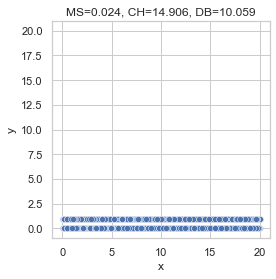

In [257]:
N = 20
X, labels = uniform_2d_clusters(20)
df = pd.DataFrame(labels, columns=['label'])
df['x'] = X[:,1]
df['y'] = X[:,0]
scores = calculate_scores(X,labels)
g = sns.scatterplot(x='x',y='y',data=df)
g.set(xlim=[-1,N+1],ylim=[-1,N+1],aspect = 1)
plt.title(', '.join([key+'='+str(np.round(val,3)) for key,val in scores.items()]))
plt.show()

# 4. Distance Analysis

### Next Steps
- [x] Alles mit Euklidischer Distanz rechnen
- [x] Nur die nächsten Nachbarn anschauen
- [x] Make nearest neighbor plot over all three nets
- [ ] Further investigate confusion matrices

## 4.1 Preprocessing 
 
Time consuming calculations. Results stored to hdf

In [32]:
# calculate euclidean distances between clusters
N = 300
df = []
dist = DistanceMetric.get_metric('euclidean')
for inet, net in enumerate(H5Reader.net_list):
    rd = H5Reader(net)
    for irace, race1 in enumerate(H5Reader.race_list):
        for jrace,race2 in enumerate(H5Reader.race_list):
            X1 = rd.read(race1).head(N).values
            X2 = rd.read(race2).tail(N).values
            distances =dist.pairwise(X1,X2).flatten().astype(np.float32)
            new_df = pd.DataFrame(distances,columns = ['distance'])
            new_df['net_index'] = np.int8(inet)
            new_df['race_index1'] = np.int8(irace)
            new_df['race_index2'] = np.int8(jrace)
            df.append(new_df)
            
# save to store
df = pd.concat(df,0)
df.to_hdf(mystore,'cluster_eucl_distances')

In [33]:
# calculate euclidean distances between clusters for 3d projection
N = 300
df = []
dist = DistanceMetric.get_metric('euclidean')
for inet, net in enumerate(H5Reader.net_list):
    rd = H5Reader(net)
    raw_df = projection3d(rd.read_all())
    for irace, race1 in enumerate(H5Reader.race_list):
        for jrace,race2 in enumerate(H5Reader.race_list):
            X1 = raw_df.query('race_index==@irace').filter(regex=r'\d').head(N).values
            X2 = raw_df.query('race_index==@jrace').filter(regex=r'\d').tail(N).values
            distances =dist.pairwise(X1,X2).flatten().astype(np.float32)
            new_df = pd.DataFrame(distances,columns = ['distance'])
            new_df['net_index'] = np.int8(inet)
            new_df['race_index1'] = np.int8(irace)
            new_df['race_index2'] = np.int8(jrace)
            df.append(new_df)
            
# save to store
df = pd.concat(df,0)
df.to_hdf(mystore,'cluster_eucl_distances_3d')

In [25]:
# !!!!!!!!!! TAKES HOURS TO RUN !!!!!!!!!!!!!!!!!
# calculate nearest neighbor euclidean distances between clusters
N = 9500 # much higher for nearest neighbor distances
df = []
for inet, net in enumerate(H5Reader.net_list):
    rd = H5Reader(net)
    for irace, race1 in enumerate(H5Reader.race_list):
        for jrace,race2 in enumerate(H5Reader.race_list):
            X1 = rd.read(race1).head(N).values
            X2 = rd.read(race2).head(N).values
            n_neighbors = 2 if race1 == race2 else 1            
            neigh = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree')
            neigh.fit(X1)
            distances, indices = neigh.kneighbors(X2)
            new_df = pd.DataFrame(distances[:,-1], columns=['distance'])
            new_df['nn_index'] = indices[:,-1]
            new_df['net_index'] = np.int8(inet)
            new_df['race_index1'] = np.int8(irace)
            new_df['race_index2'] = np.int8(jrace)
            df.append(new_df)

# save to store
df = pd.concat(df,0)
df.to_hdf(mystore,'nn_eucl_distances')

In [21]:
df = pd.read_hdf(mystore,'nn_eucl_distances')
df.query('net_index==0').head(15)

,distance,nn_index,net_index,race_index1,race_index2
0,0.934786,8517,0,0,0
1,0.948649,6090,0,0,0
2,0.813971,1716,0,0,0
3,0.596464,5,0,0,0
4,0.686765,3,0,0,0
5,0.596464,3,0,0,0
6,0.680216,5,0,0,0
7,0.469712,8,0,0,0
8,0.469712,7,0,0,0
9,0.628257,7,0,0,0


In [22]:
r128 = H5Reader('senet50_128')
r128.read_all(N=9500,key='/images').head(15)

,race_index,class,subject,img
0,0,Caucasian,m.0cl29w,m.0cl29w_0001.jpg
1,0,Caucasian,m.0cl29w,m.0cl29w_0003.jpg
2,0,Caucasian,m.0cl29w,m.0cl29w_0002.jpg
3,0,Caucasian,m.02qtdjx,m.02qtdjx_0004.jpg
4,0,Caucasian,m.02qtdjx,m.02qtdjx_0003.jpg
5,0,Caucasian,m.02qtdjx,m.02qtdjx_0002.jpg
6,0,Caucasian,m.02qtdjx,m.02qtdjx_0001.jpg
7,0,Caucasian,m.072d5h,m.072d5h_0002.jpg
8,0,Caucasian,m.072d5h,m.072d5h_0003.jpg
9,0,Caucasian,m.072d5h,m.072d5h_0001.jpg


## 4.2 Distance distributions 

Plots in this section show
- Violin plots of (euclidean) distance distribution
- The distances are between points of same clusters (diagonal case) or between points of different clusters (off-diagonal cas)
- The distributions represent either all pairwise distances (pair case) or distances to neares neighbors (nn case)

C:\Users\wehs\.conda\envs\ds\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\wehs\.conda\envs\ds\lib\site-packages\seaborn\axisgrid.py:650: UserWarning: Using the violinplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


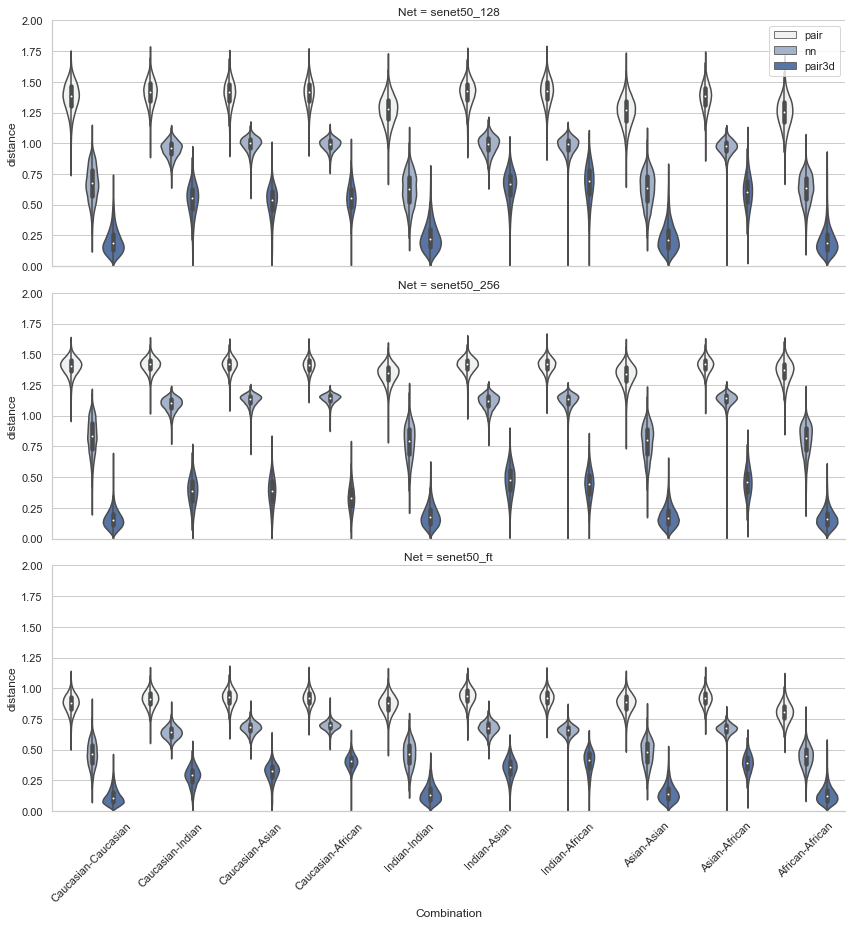

In [38]:
%matplotlib inline
df = pd.concat(
    [pd.read_hdf(mystore,'cluster_eucl_distances').assign(type1='pair'),
     pd.read_hdf(mystore,'nn_eucl_distances').assign(type1='nn'),
     pd.read_hdf(mystore,'cluster_eucl_distances_3d').assign(type1='pair3d')
     ],0).query('race_index2 >= race_index1')
df['Combination'] = df.race_index1.apply(H5Reader.race) + '-' + df.race_index2.apply(H5Reader.race)
df['Net'] = df.net_index.apply(H5Reader.net)

sns.set_theme(style="whitegrid")
g = sns.FacetGrid(df,row='Net',aspect=3,height=4, legend_out=True)
g.map(sns.violinplot, 'Combination','distance','type1')
g.set(ylim=(0, 2))
g.set_xticklabels(rotation=45)
g.fig.get_axes()[0].legend()

### Condensed distributions

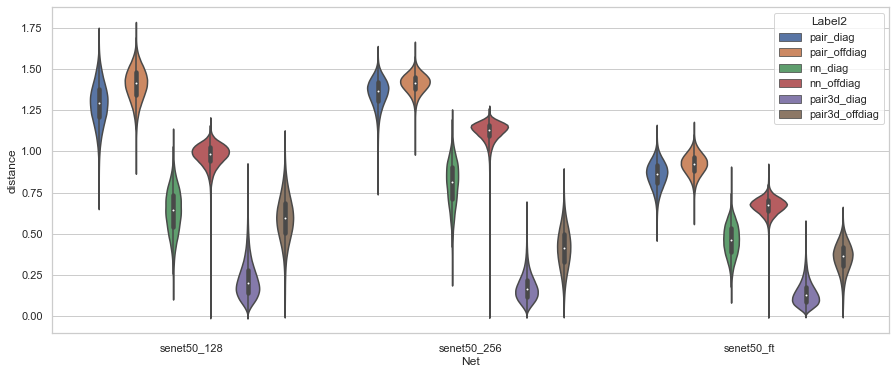

In [39]:
df['type2'] = (df.race_index1 == df.race_index2).apply(lambda b: 'diag' if b else 'offdiag')
df['Label2'] = df.type1 + '_' + df.type2
plt.figure(figsize=(15,6))
sns.violinplot(x='Net',y='distance',hue='Label2',data=df)

### Fraction of points which are nearest neighbors

In off-diagonal distances, still 30% of points are nearest neighbors!

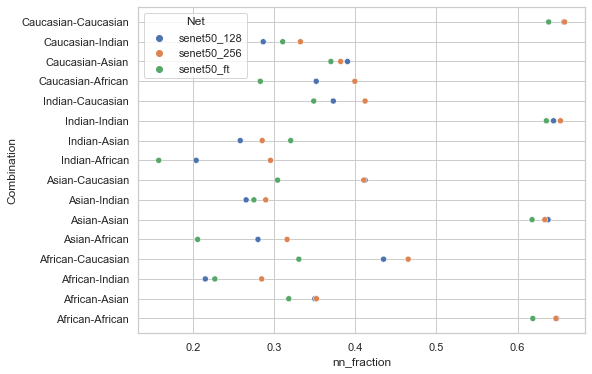

In [186]:
tmp = (df.query("type1=='nn'")
     .groupby(['net_index','race_index1','race_index2'])
     .apply(lambda df: pd.Series({'nn_fraction':len(df.nn_index.unique())/9500,
                                  'Combination':df.Combination[0],
                                 'Net':df.Net[0]})))
tmp = pd.DataFrame(tmp).reset_index()
plt.figure(figsize=(8,6))
g = sns.scatterplot(y='Combination',x='nn_fraction',hue='Net',data=tmp)

# 5 PCA

### Full data

In [111]:
N = 9500
n_components = 8
pcadf = []
pca = PCA(n_components=n_components)
for net in H5Reader.net_list:
    df = H5Reader(net).read_all(N)
    X,_ = H5Reader.df2data(df)
    df = H5Reader.replacedata(df,pca.fit_transform(X))
    df['Net']=net
    pcadf.append(df.set_index(['race_index','Net']).stack().reset_index())

pcadf = pd.concat(pcadf,0).rename(columns={'level_2':'pca_index',0:'value'})
pcadf['race'] = pcadf.race_index.apply(H5Reader.race)

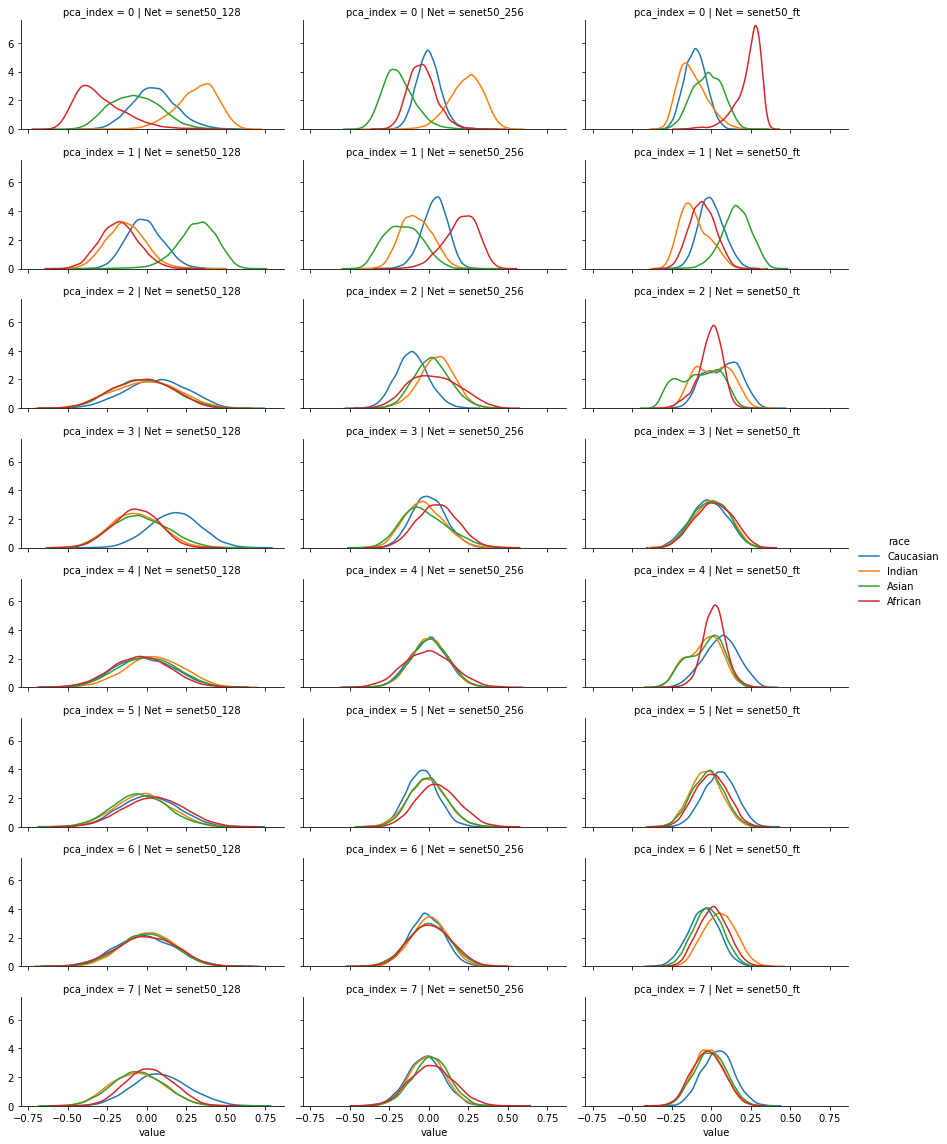

In [112]:
g = sns.FacetGrid(pcadf,col='Net',row='pca_index',hue='race',aspect=2,height=2, legend_out=True)
g.map(sns.kdeplot, 'value')
g.add_legend()

### racially blinded data

In [113]:
N = 9500
n_components = 8
pcadf = []
pca = PCA(n_components=n_components)
for net in H5Reader.net_list:
    df = H5Reader(net).read_all(N)
    X,y = H5Reader.df2data(df)
    ccp = ClusterCenterProjection()
    ccp.fit(X,y)
    df = H5Reader.replacedata(df,pca.fit_transform(ccp.blind(X)))
    df['Net']=net
    pcadf.append(df.set_index(['race_index','Net']).stack().reset_index())

pcadf = pd.concat(pcadf,0).rename(columns={'level_2':'pca_index',0:'value'})
pcadf['race'] = pcadf.race_index.apply(H5Reader.race)

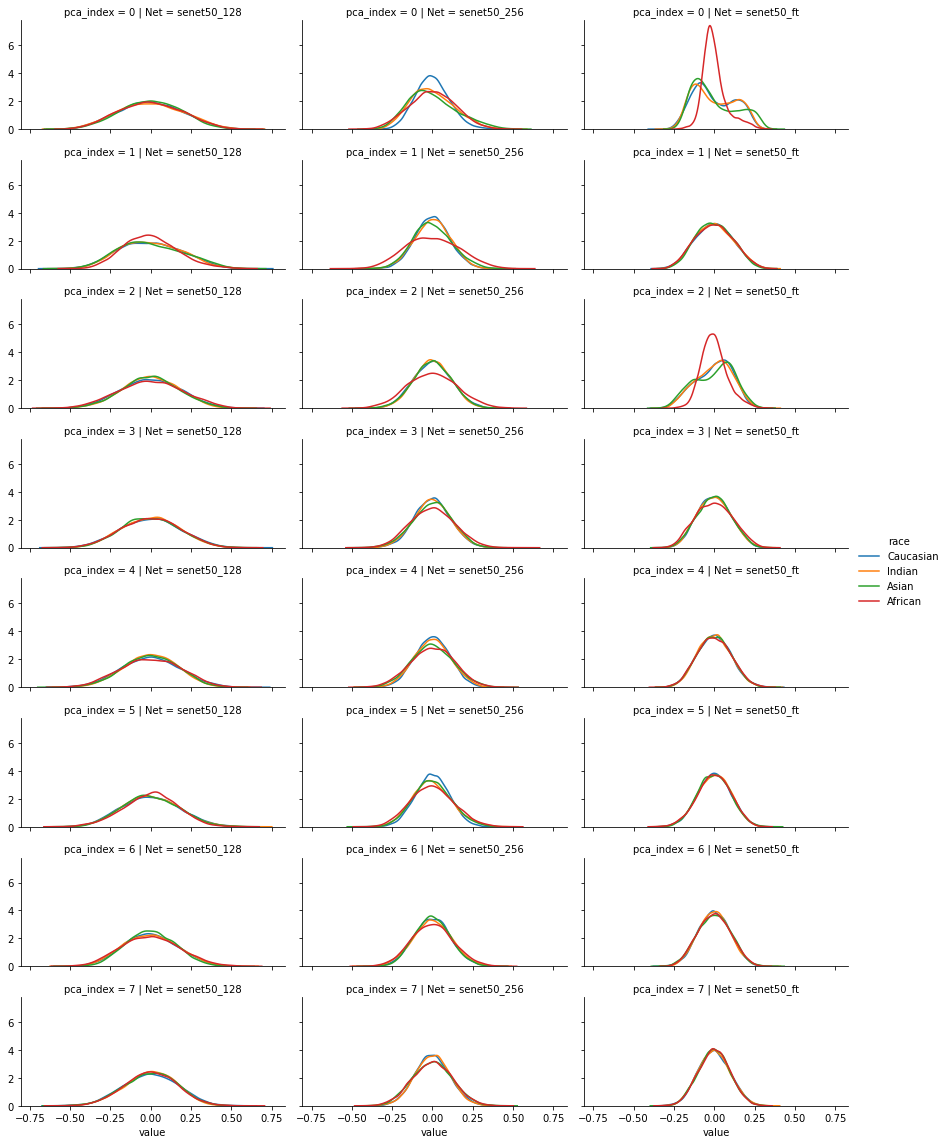

In [114]:
g = sns.FacetGrid(pcadf,col='Net',row='pca_index',hue='race',aspect=2,height=2, legend_out=True)
g.map(sns.kdeplot, 'value')
g.add_legend()

# 6. RFW Pair metric for face recogition

### Insights

- The good classification threshold depends on the race. Caucasian has higher threshold
- Blinding with respect to race does not hurt the accuracy
- Blinding with respect to race aligns the accuracy peaks for cosine distances
- As a consequence, it increases the total accuracy!!!

To do:
- [ ] check whether total accuracy increases with removal of race dimensions

In [338]:
r128 = H5Reader('senet50_128')
tmp = r128.read_all()
embeddings,race_labels = H5Reader.df2data(r128.read_all())
pair_labels = r128.read_pair_labels()

frm = RFWDistances()
ccp = ClusterCenterProjection()

cdf = []
for net in H5Reader.net_list:
    reader = H5Reader(net)
    tmp = reader.read_all()
    embeddings,race_labels = H5Reader.df2data(reader.read_all())
    pair_labels = r128.read_pair_labels()
    ccp.fit(embeddings,race_labels)
    
    for projection, X in {'full':embeddings, 
                          'race un-aware':ccp.blind(embeddings),
                          'race only (3d)':ccp.project(embeddings)}.items():
        df = frm.get_distance_df(X,pair_labels).dropna()

        for th in np.arange(0,1.5,0.01):
            df['eucl_metric'] = df.issame == (df.eucl < th)
            df['cos_metric'] = df.issame == (df.cos < th)
            tmp = df.groupby('race')[['eucl_metric','cos_metric']].mean()
            tmp.loc['Total',:] = df[['eucl_metric','cos_metric']].mean()
            tmp['threshold'] = th
            tmp['projection'] = projection
            tmp['net'] = net
            cdf.append(tmp)

cdf = pd.concat(cdf,0).reset_index()
cdf2 = (cdf.set_index(['race','threshold','projection','net'])
        .stack().reset_index()
        .rename(columns={'level_4':'dist_type',0:'accuracy','projection':'subspace structure'})  )

cdf2.head(10)

,race,threshold,subspace structure,net,dist_type,accuracy
0,African,0.0,full,senet50_128,eucl_metric,0.499916
1,African,0.0,full,senet50_128,cos_metric,0.499916
2,Asian,0.0,full,senet50_128,eucl_metric,0.500848
3,Asian,0.0,full,senet50_128,cos_metric,0.500848
4,Caucasian,0.0,full,senet50_128,eucl_metric,0.500849
5,Caucasian,0.0,full,senet50_128,cos_metric,0.500849
6,Indian,0.0,full,senet50_128,eucl_metric,0.500424
7,Indian,0.0,full,senet50_128,cos_metric,0.500424
8,Total,0.0,full,senet50_128,eucl_metric,0.500507
9,Total,0.0,full,senet50_128,cos_metric,0.500507


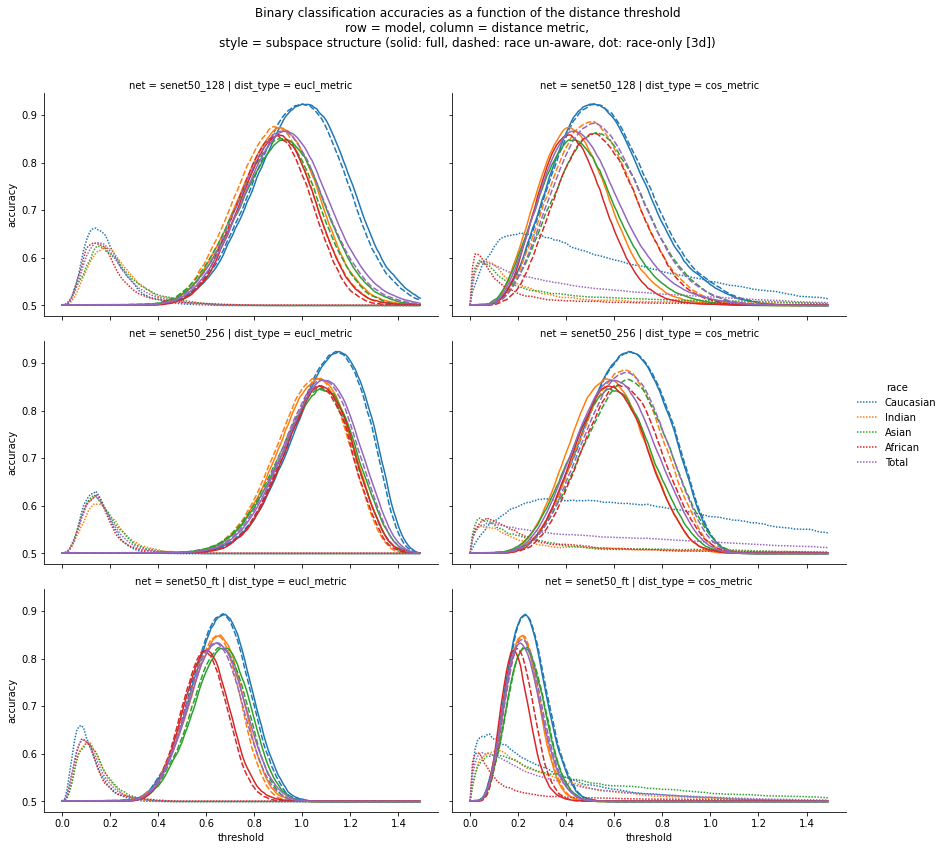

In [341]:
g = sns.FacetGrid(cdf2,row='net',col='dist_type',hue='race', hue_order=H5Reader.race_list+['Total'],
                  aspect=1.5,height=4, legend_out=True)
g.map_dataframe(sns.lineplot,'threshold','accuracy',style = 'subspace structure')
g.add_legend()
plt.subplots_adjust(top=0.88)
g.fig.suptitle('\n'.join(['Binary classification accuracies as a function of the distance threshold', 
                          'row = model, column = distance metric,',
                          'style = subspace structure (solid: full, dashed: race un-aware, dot: race-only [3d])']))

plt.savefig('plots/FR_accuracies.png',papertype='A4',dpi=200)
plt.show()

### Maxima of accuracies

In [337]:
cdf2.groupby(['net','race','dist_type','projection'])[['accuracy']].max().unstack(level=[-2,-1])

accuracy                                            \
dist_type             cos_metric                     eucl_metric             
projection                    3d     blind      full          3d     blind   
net         race                                                             
senet50_128 African     0.607459  0.860846  0.858170    0.631042  0.856832   
            Asian       0.594333  0.863251  0.847811    0.624703  0.850187   
            Caucasian   0.651886  0.923717  0.923038    0.662249  0.923208   
            Indian      0.594264  0.887663  0.874258    0.622264  0.875785   
            Total       0.591366  0.882885  0.865635    0.631448  0.865846   
senet50_256 African     0.574344  0.853989  0.851480    0.623683  0.851815   
            Asian       0.573804  0.865626  0.845945    0.620631  0.845945   
            Caucasian   0.614679  0.923887  0.924567    0.630479  0.924567   
            Indian      0.557441  0.885966  0.866452    0.603258  0.868149   
            Total       0.563250  0.880518  0.863352    0.619440  0.864240   
senet50_ft  African     0.602275  0.821040  0.817361    0.630206  0.815855   
            Asian       0.599084  0.823549  0.821513    0.623176  0.823210   
            Caucasian   0.641352  0.891777  0.893306    0.659531  0.894495   
            Indian      0.606991  0.848464  0.848634    0.624300  0.847955   
            Total       0.602232  0.840436  0.832784    0.628404  0.832741   

                                 
dist_type                        
projection                 full  
net         race                 
senet50_128 African    0.858839  
            Asian      0.847642  
            Caucasian  0.923038  
            Indian     0.873749  
            Total      0.865931  
senet50_256 African    0.852316  
            Asian      0.847302  
            Caucasian  0.924397  
            Indian     0.866452  
            Total      0.863944  
senet50_ft  African    0.817361  
            Asian      0.821853  
            Caucasian  0.892966  
            Indian     0.849652  
            Total      0.833164

# xxx. Other stuff

PCA calculates normalized variance $p_i$ such that $\sum p_i = 1$. Here I define a variance spread as

$$ h = \sum_i i * p_i $$

- Bigger h means that variance spreads over more components, i.e. more dimensions. 
- Below: h is calculated with a seperate pca for each class.
- Fit is done with a fit-paremeter per model

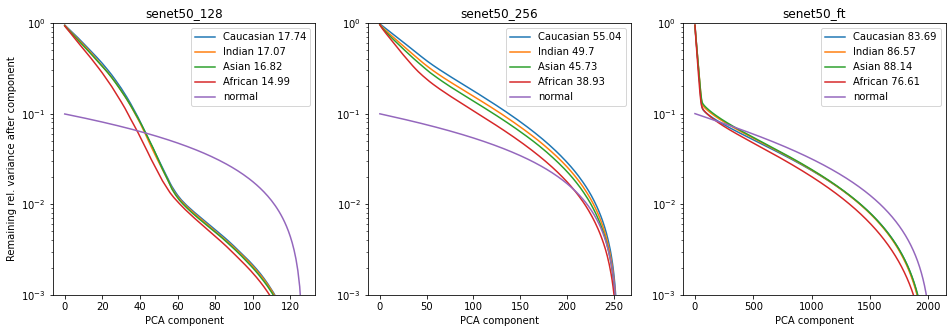

In [93]:
pca = PCA(svd_solver='full')
N=9500

hmat = np.zeros([3,4])
fig, axs = plt.subplots(1, 3, figsize=(16,5))
for inet,net in enumerate(H5Reader.net_list):
    rd = H5Reader(net)
    for irace,race in enumerate(H5Reader.race_list):
        X = rd.read(race).head(N).values
        #X = X - np.mean(X,0,keepdims=True)
        pca.fit(X)
        var = pca.explained_variance_ratio_
        #var = var/np.sum(var)
        h = np.dot(var,np.arange(len(var)))
        hmat[inet,irace]=h
        axs[inet].semilogy(1 - np.cumsum(var),label=race+' '+str(np.round(h,2)))
    
    pca.fit(np.random.normal(size=[N,X.shape[1]]))
    var = pca.explained_variance_ratio_
    axs[inet].semilogy((1 - np.cumsum(var))/10,label='normal')

    axs[inet].legend()
    axs[inet].set_title('senet50_'+net)
    axs[inet].set_ylim([0.001,1])
    #axs[inet].set_xlim([0,150])
    axs[inet].set_xlabel('PCA component')
    
    if inet == 0:
        axs[inet].set_ylabel('Remaining rel. variance after component')
    
plt.show()

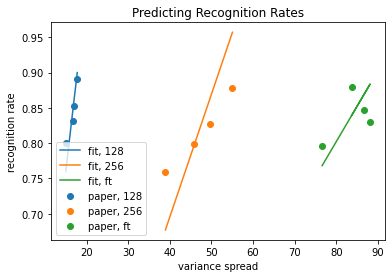

In [86]:
# recognition rate
recrate=[[0.8906,0.8531,0.8310,0.7998],
        [0.8787,0.8265,0.7981,0.7597],
        [0.8799,0.8472,0.8305,0.7959]]

recrate_fit = hmat*np.mean(recrate/hmat,1,keepdims=1)

for inet, net in enumerate(H5Reader.net_list):
    plt.scatter(hmat[inet],recrate[inet],label='paper, ' + net)
    plt.plot(hmat[inet],recrate_fit[inet],label='fit, '+net)
plt.legend()
plt.xlabel('variance spread')
plt.ylabel('recognition rate')
plt.title('Predicting Recognition Rates')
plt.show()